In [1]:
!cat /proc/cpuinfo
!cat /proc/meminfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 7
microcode	: 0xffffffff
cpu MHz		: 2200.172
cache size	: 39424 KB
physical id	: 0
siblings	: 12
core id		: 0
cpu cores	: 6
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp ibrs_enhanced fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat avx512_vnni md_clear arch_capabilities
bugs		: spectre_v1 spectre_v2 spec_store_bypass swapgs ta

In [2]:
!nvidia-smi

Thu Dec 12 12:03:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0              43W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [3]:
!python --version

Python 3.10.12


In [4]:
!uname -a

Linux 2cb2a8eecdab 6.1.85+ #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024 x86_64 x86_64 x86_64 GNU/Linux


In [5]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         236G   33G  204G  14% /
tmpfs            64M     0   64M   0% /dev
shm              41G     0   41G   0% /dev/shm
/dev/root       2.0G  1.2G  820M  59% /usr/sbin/docker-init
/dev/sda1       242G   35G  208G  15% /kaggle/input
tmpfs            42G   40K   42G   1% /var/colab
tmpfs            42G     0   42G   0% /proc/acpi
tmpfs            42G     0   42G   0% /proc/scsi
tmpfs            42G     0   42G   0% /sys/firmware


In [1]:
!pip install opencv-python-headless
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117
# !pip install cython albumentations
# !pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

Looking in indexes: https://download.pytorch.org/whl/cu117


In [7]:
!rm -rf detectron2

!git clone https://github.com/facebookresearch/detectron2.git

%cd detectron2
!pip install -e .

Cloning into 'detectron2'...
remote: Enumerating objects: 15819, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 15819 (delta 31), reused 47 (delta 17), pack-reused 15743 (from 1)
Receiving objects: 100% (15819/15819), 6.38 MiB | 22.86 MiB/s, done.
Resolving deltas: 100% (11527/11527), done.
/content/detectron2
Obtaining file:///content/detectron2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB

In [18]:
import os
import cv2
import json
import torch
import random
import detectron2
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.structures import BoxMode
from detectron2.structures import Instances
from detectron2.data.transforms import AugInput
from detectron2.utils.visualizer import Visualizer
from concurrent.futures import ProcessPoolExecutor
from detectron2.utils.events import get_event_storage
from detectron2.projects.point_rend import add_pointrend_config
from detectron2.model_zoo import get_config_file, get_checkpoint_url
from detectron2.engine import DefaultPredictor, DefaultTrainer, hooks
from detectron2.modeling.roi_heads import StandardROIHeads,ROI_HEADS_REGISTRY
from detectron2.evaluation import COCOEvaluator, DatasetEvaluators, inference_on_dataset
from detectron2.data import build_detection_test_loader, MetadataCatalog, DatasetCatalog, DatasetMapper, build_detection_train_loader, build_batch_data_loader, MapDataset


print("Detectron2 installation successful!")

Detectron2 installation successful!


In [3]:
from google.colab import files, drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
label_mapping_filepath = '/content/drive/MyDrive/UECFOODPIXCOMPLETE/data/category.txt'

label_mapping = {}
with open(label_mapping_filepath, 'r') as f:
    for line in f:
      label, food_name = line.strip().split(maxsplit=1)
      label_mapping[int(label)] = food_name

if 0 in label_mapping:
    del label_mapping[0]

label_mapping[0] = 'background'
# label_mapping[255] = "ignored"
print(len(label_mapping))
print(label_mapping)

103
{1: 'rice', 2: 'eels on rice', 3: 'pilaf', 4: "chicken-'n'-egg on rice", 5: 'pork cutlet on rice', 6: 'beef curry', 7: 'sushi', 8: 'chicken rice', 9: 'fried rice', 10: 'tempura bowl', 11: 'bibimbap', 12: 'toast', 13: 'croissant', 14: 'roll bread', 15: 'raisin bread', 16: 'chip butty', 17: 'hamburger', 18: 'pizza', 19: 'sandwiches', 20: 'udon noodle', 21: 'tempura udon', 22: 'soba noodle', 23: 'ramen noodle', 24: 'beef noodle', 25: 'tensin noodle', 26: 'fried noodle', 27: 'spaghetti', 28: 'Japanese-style pancake', 29: 'takoyaki', 30: 'gratin', 31: 'sauteed vegetables', 32: 'croquette', 33: 'grilled eggplant', 34: 'sauteed spinach', 35: 'vegetable tempura', 36: 'miso soup', 37: 'potage', 38: 'sausage', 39: 'oden', 40: 'omelet', 41: 'ganmodoki', 42: 'jiaozi', 43: 'stew', 44: 'teriyaki grilled fish', 45: 'fried fish', 46: 'grilled salmon', 47: 'salmon meuniere', 48: 'sashimi', 49: 'grilled pacific saury', 50: 'sukiyaki', 51: 'sweet and sour pork', 52: 'lightly roasted fish', 53: 'steam

In [5]:
train_image_dir = '/content/drive/MyDrive/UECFOODPIXCOMPLETE/data/UECFoodPIXCOMPLETE/train/img'
train_annotation_dir = '/content/drive/MyDrive/UECFOODPIXCOMPLETE/data/UECFoodPIXCOMPLETE/train/mask'
# train_output_json_path = '/content/drive/MyDrive/Thesis/FoodSeg103/Images/img_dir/annotations/train_annotations.json'

test_image_dir = '/content/drive/MyDrive/UECFOODPIXCOMPLETE/data/UECFoodPIXCOMPLETE/test/img'
test_annotation_dir = '/content/drive/MyDrive/UECFOODPIXCOMPLETE/data/UECFoodPIXCOMPLETE/test/mask'
# test_output_json_path = '/content/drive/MyDrive/Thesis/FoodSeg103/Images/img_dir/annotations/test_annotations.json'

In [6]:
test_img_files = sorted(os.listdir(test_image_dir))
train_img_files = sorted(os.listdir(train_image_dir))
test_annotation_files = sorted(os.listdir(test_annotation_dir))
train_annotation_files = sorted(os.listdir(train_annotation_dir))

print(len(test_img_files))
print(len(train_img_files))
print(len(test_annotation_files))
print(len(train_annotation_files))

1000
9000
1000
9000


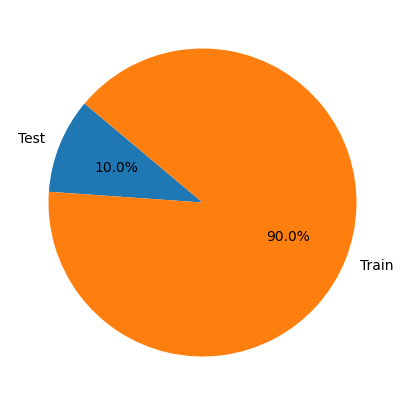

In [7]:
labels = ['Test', 'Train']
sizes = [len(test_img_files), len(train_img_files)]

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
# plt.title("Distribution of Test and Train Datasets - UECFOODPIXCOMPLETE")
plt.show()

Processing 1271.jpg...


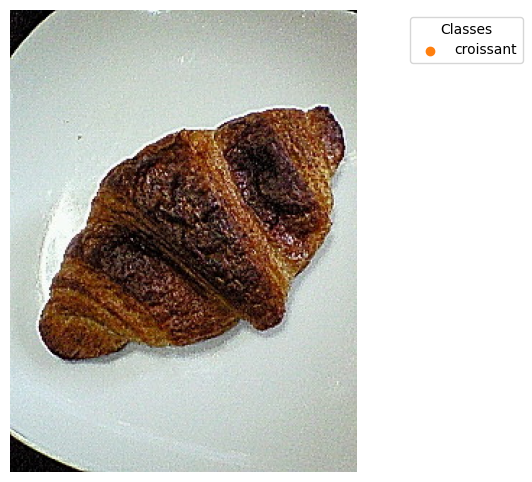

Processing 4586.jpg...


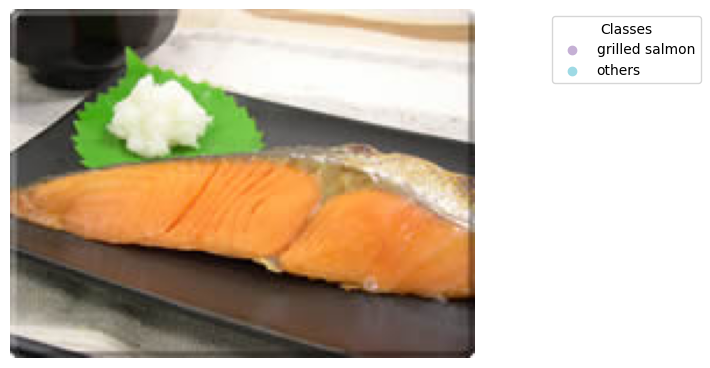

Processing 4013.jpg...


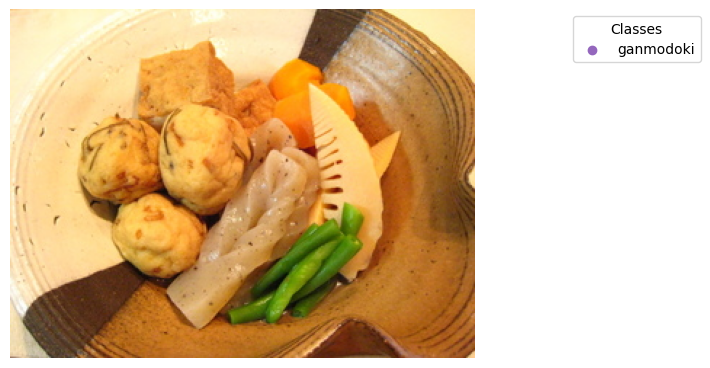

Processing 3956.jpg...


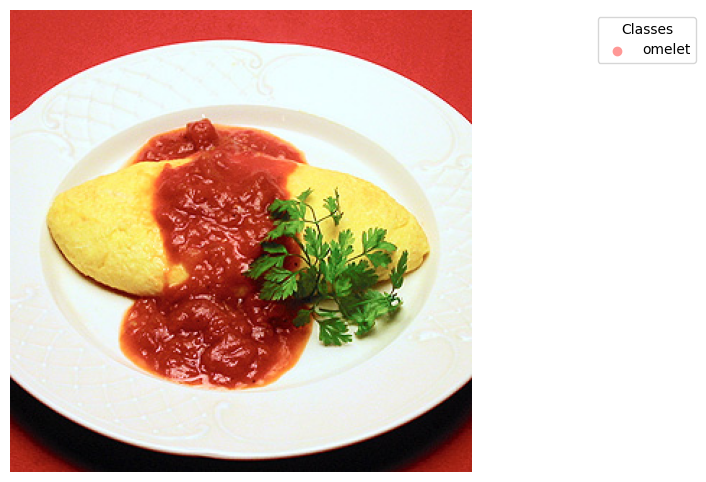

Processing 7856.jpg...


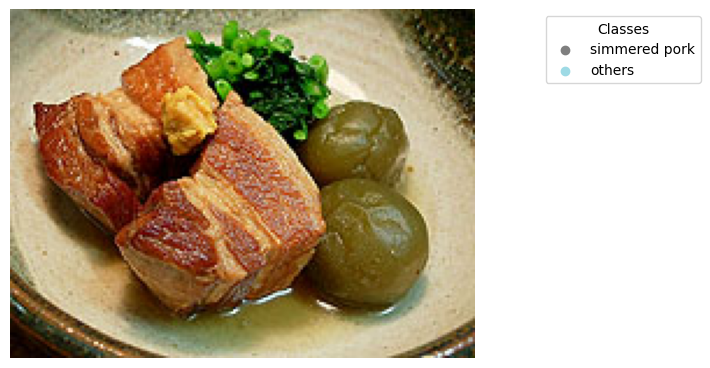

Processing 771.jpg...


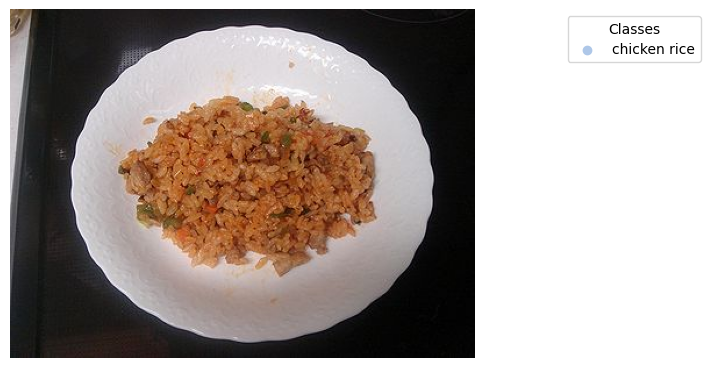

Processing 3357.jpg...


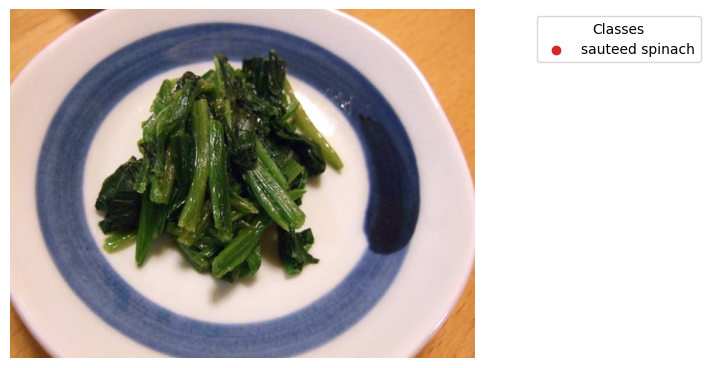

Processing 6042.jpg...


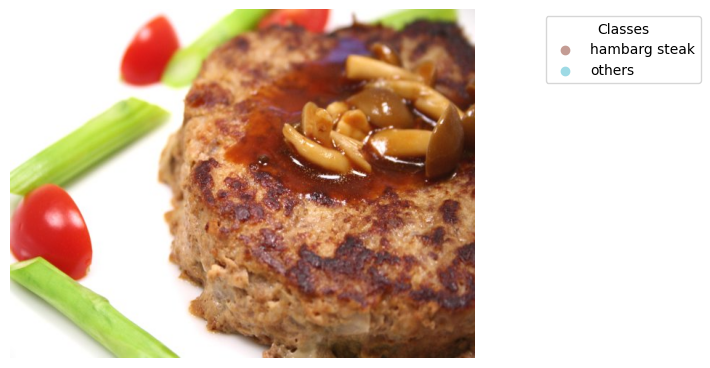

Processing 8614.jpg...


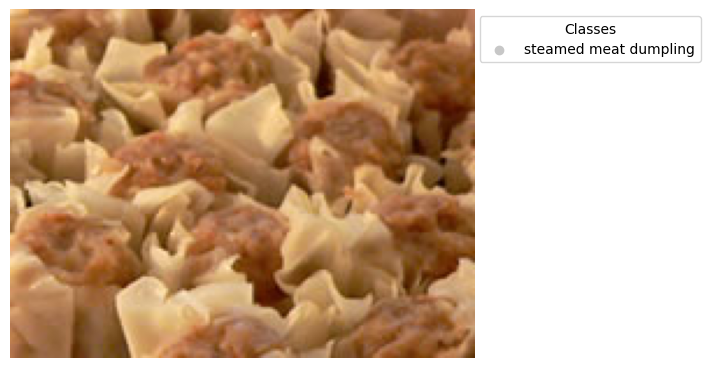

Processing 3778.jpg...


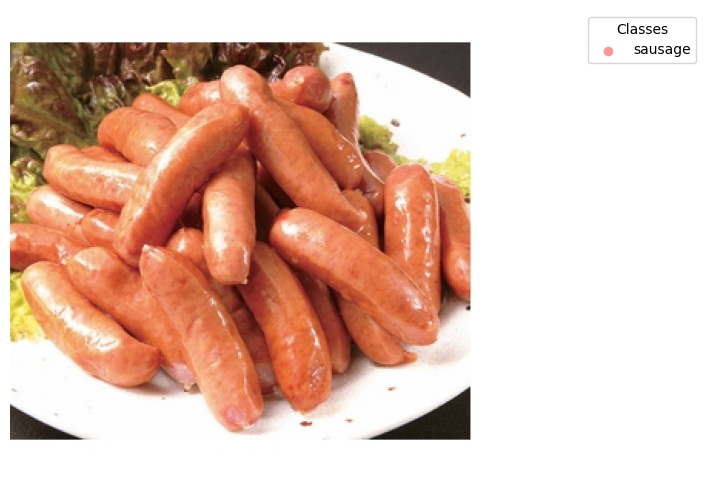

In [26]:
color_palette = plt.cm.tab20(np.linspace(0, 1, len(label_mapping)))[:, :3] * 255

def visualize_image_with_labels(image_path, mask_path, label_mapping):
    image = np.array(Image.open(image_path))
    mask_image = Image.open(mask_path)
    mask = np.array(mask_image)[:, :, 0]

    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis("off")

    unique_labels = np.unique(mask)
    for label_id in unique_labels:
        if label_id == 0:
            continue
        if label_id == 103:
            continue
        plt.scatter([], [], color=color_palette[label_id % len(color_palette)] / 255, label=label_mapping.get(label_id, "Unknown"))

    plt.legend(loc="upper right", title="Classes", bbox_to_anchor=(1.5, 1))
    plt.show()

sampled_images = random.sample(train_img_files, 10)

for image_name in sampled_images:
    image_path = os.path.join(train_image_dir, image_name)
    mask_path = os.path.join(train_annotation_dir, os.path.splitext(image_name)[0] + ".png")

    if os.path.exists(mask_path):
        print(f"Processing {image_name}...")

        visualize_image_with_labels(image_path, mask_path, label_mapping)

Conversion of Images & Annotations into COCO format

In [40]:
def process_single_image(filename, image_dir, annotation_dir):
    record = {}
    image_path = os.path.join(image_dir, filename)
    annotation_path = os.path.join(annotation_dir, filename.replace('.jpg', '.png'))

    try:
        with Image.open(image_path) as img:
            img = ImageOps.exif_transpose(img)
            width, height = img.size
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

    annotation_image = cv2.imread(annotation_path)
    if annotation_image is None:
        print(f"Warning: Could not load annotation {annotation_path}. Skipping this file.")
        return None

    annotation_image = annotation_image[:, :, 2]

    record["file_name"] = image_path
    record["image_id"] = filename
    record["height"] = height
    record["width"] = width
    record["sem_seg_file_name"] = annotation_path

    objs = []
    unique_labels = np.unique(annotation_image)

    for label in unique_labels:
        if label == 0:
            continue
        if label == 101:
            continue

        mask = (annotation_image == label).astype(np.uint8)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            if len(contour) < 3:
                continue
            bbox = cv2.boundingRect(contour)
            obj = {
                "bbox": [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]],
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": label,
                "segmentation": [contour.flatten().tolist()],
            }
            objs.append(obj)

    record["annotations"] = objs
    return record

def process_image_with_dirs(args):
    filename, image_dir, annotation_dir = args
    return process_single_image(filename, image_dir, annotation_dir)

def get_foodseg103_dicts_parallel(image_dir, annotation_dir):
    image_files = sorted(os.listdir(image_dir))
    args = [(filename, image_dir, annotation_dir) for filename in image_files]

    with ProcessPoolExecutor() as executor:
        dataset_dicts = list(executor.map(process_image_with_dirs, args))

    return [record for record in dataset_dicts if record is not None]

train_dataset_dicts = get_foodseg103_dicts_parallel(train_image_dir, train_annotation_dir)
test_dataset_dicts = get_foodseg103_dicts_parallel(test_image_dir, test_annotation_dir)

In [9]:
def count_instances_detectron2(dataset_dicts, label_mapping):
    counts = {}

    for record in dataset_dicts:
        for annotation in record['annotations']:
            category_id = annotation['category_id']
            counts[category_id] = counts.get(category_id, 0) + 1

    sorted_counts = dict(sorted(counts.items()))

    print("Instance counts for Detectron2 (sorted by category ID):")
    for category_id, count in sorted_counts.items():
        class_name = label_mapping.get(category_id, "Unknown")
        print(f"Category {category_id} ({class_name}): {count}")

    return sorted_counts

In [10]:
test_detectron2_counts = count_instances_detectron2(test_dataset_dicts, label_mapping)

Instance counts for Detectron2 (sorted by category ID):
Category 1 (rice): 109
Category 2 (eels on rice): 13
Category 3 (pilaf): 9
Category 4 (chicken-'n'-egg on rice): 9
Category 5 (pork cutlet on rice): 18
Category 6 (beef curry): 23
Category 7 (sushi): 13
Category 8 (chicken rice): 8
Category 9 (fried rice): 15
Category 10 (tempura bowl): 16
Category 11 (bibimbap): 8
Category 12 (toast): 32
Category 13 (croissant): 12
Category 14 (roll bread): 23
Category 15 (raisin bread): 16
Category 16 (chip butty): 15
Category 17 (hamburger): 33
Category 18 (pizza): 18
Category 19 (sandwiches): 26
Category 20 (udon noodle): 17
Category 21 (tempura udon): 16
Category 22 (soba noodle): 29
Category 23 (ramen noodle): 54
Category 24 (beef noodle): 32
Category 25 (tensin noodle): 9
Category 26 (fried noodle): 24
Category 27 (spaghetti): 18
Category 28 (Japanese-style pancake): 26
Category 29 (takoyaki): 18
Category 30 (gratin): 13
Category 31 (sauteed vegetables): 16
Category 32 (croquette): 15
Categ

In [11]:
train_detectron2_counts = count_instances_detectron2(train_dataset_dicts, label_mapping)

Instance counts for Detectron2 (sorted by category ID):
Category 1 (rice): 1221
Category 2 (eels on rice): 113
Category 3 (pilaf): 127
Category 4 (chicken-'n'-egg on rice): 105
Category 5 (pork cutlet on rice): 167
Category 6 (beef curry): 285
Category 7 (sushi): 186
Category 8 (chicken rice): 160
Category 9 (fried rice): 171
Category 10 (tempura bowl): 177
Category 11 (bibimbap): 107
Category 12 (toast): 248
Category 13 (croissant): 152
Category 14 (roll bread): 123
Category 15 (raisin bread): 98
Category 16 (chip butty): 224
Category 17 (hamburger): 245
Category 18 (pizza): 122
Category 19 (sandwiches): 198
Category 20 (udon noodle): 209
Category 21 (tempura udon): 191
Category 22 (soba noodle): 194
Category 23 (ramen noodle): 475
Category 24 (beef noodle): 229
Category 25 (tensin noodle): 123
Category 26 (fried noodle): 218
Category 27 (spaghetti): 189
Category 28 (Japanese-style pancake): 152
Category 29 (takoyaki): 171
Category 30 (gratin): 120
Category 31 (sauteed vegetables): 13

In [12]:
def calculate_class_weights(class_counts):
    total_instances = sum(class_counts.values())

    weights = {category_id: 1.0 / (count + 1e-6) for category_id, count in class_counts.items()}

    total_weight = sum(weights.values())
    # print(total_weight)
    normalized_weights = {category_id: weight / total_weight for category_id, weight in weights.items()}

    return normalized_weights

In [13]:
class_weights = []

class_weights_dict = calculate_class_weights(train_detectron2_counts)
print(f"Length of label mapping: {len(label_mapping)}")

for i in range(0, len(label_mapping) + 1):
    class_weights.append(class_weights_dict.get(i, 0))
class_weights.pop()

print(f"Class weights: {class_weights}")
print(f"Length of class weights: {len(class_weights)}")

Length of label mapping: 103
Class weights: [0, 0.0012471522253213647, 0.013475865972466132, 0.011990337451765365, 0.014502598608208956, 0.009118400354767296, 0.005343062677268338, 0.008186950861169827, 0.009517330367795052, 0.008905104441283241, 0.008603236495826568, 0.014231522001243146, 0.006140213154130345, 0.010018242489120371, 0.012380267121823347, 0.015538498498224902, 0.00679809313199306, 0.006215399437343425, 0.012481744720350772, 0.007690772023604883, 0.0072859945506150445, 0.007972632776920974, 0.007849344641830897, 0.0032058376108604235, 0.006649663151593344, 0.012380267121823347, 0.0069851966118318455, 0.008056999260886452, 0.010018242489120371, 0.008905104441283241, 0.01268977379728971, 0.010955200413016824, 0.007182890854630416, 0.013015152609823813, 0.013475865972466132, 0.007613864303753372, 0.0016697070906741575, 0.01655187882405065, 0.007690772023604883, 0.009342164779278368, 0.008275939457003258, 0.011713637358853089, 0.009637802903333772, 0.013357656622867389, 0.01

In [14]:
print("Normalized Class Weights:")
for category_id, weight in class_weights_dict.items():
    class_name = label_mapping.get(category_id, "Unknown")
    print(f"Category {category_id} ({class_name}): {weight:.6f}")

Normalized Class Weights:
Category 1 (rice): 0.001247
Category 2 (eels on rice): 0.013476
Category 3 (pilaf): 0.011990
Category 4 (chicken-'n'-egg on rice): 0.014503
Category 5 (pork cutlet on rice): 0.009118
Category 6 (beef curry): 0.005343
Category 7 (sushi): 0.008187
Category 8 (chicken rice): 0.009517
Category 9 (fried rice): 0.008905
Category 10 (tempura bowl): 0.008603
Category 11 (bibimbap): 0.014232
Category 12 (toast): 0.006140
Category 13 (croissant): 0.010018
Category 14 (roll bread): 0.012380
Category 15 (raisin bread): 0.015538
Category 16 (chip butty): 0.006798
Category 17 (hamburger): 0.006215
Category 18 (pizza): 0.012482
Category 19 (sandwiches): 0.007691
Category 20 (udon noodle): 0.007286
Category 21 (tempura udon): 0.007973
Category 22 (soba noodle): 0.007849
Category 23 (ramen noodle): 0.003206
Category 24 (beef noodle): 0.006650
Category 25 (tensin noodle): 0.012380
Category 26 (fried noodle): 0.006985
Category 27 (spaghetti): 0.008057
Category 28 (Japanese-style

Dataset Registration

In [33]:
sorted_label_mapping = dict(sorted(label_mapping.items()))

if "foodseg103_train" in DatasetCatalog.list():
    DatasetCatalog.remove("foodseg103_train")
if "foodseg103_test" in DatasetCatalog.list():
    DatasetCatalog.remove("foodseg103_test")

if "foodseg103_train" in MetadataCatalog.list():
    MetadataCatalog.remove("foodseg103_train")
if "foodseg103_test" in MetadataCatalog.list():
    MetadataCatalog.remove("foodseg103_test")

DatasetCatalog.register("foodseg103_test", lambda: get_foodseg103_dicts_parallel(test_image_dir, test_annotation_dir))
DatasetCatalog.register("foodseg103_train", lambda: get_foodseg103_dicts_parallel(train_image_dir, train_annotation_dir))

MetadataCatalog.get("foodseg103_test").set(thing_classes=list(sorted_label_mapping.values()))
MetadataCatalog.get("foodseg103_train").set(thing_classes=list(sorted_label_mapping.values()))

foodseg_metadata_test = MetadataCatalog.get("foodseg103_test")
foodseg_metadata_train = MetadataCatalog.get("foodseg103_train")

In [ ]:
print(f"Number of thing_classes: { len(MetadataCatalog.get('foodseg103_test').thing_classes) }")
print(f"Number of thing_classes: { len(MetadataCatalog.get('foodseg103_train').thing_classes) }")

Number of thing_classes: 103
Number of thing_classes: 103


Model Training

In [27]:
from detectron2.data.transforms import Transform, Augmentation

class GaussianNoiseTransform(Transform):
    def __init__(self, mean=0, std=0.01):
        super().__init__()
        self.mean = mean
        self.std = std

    def apply_image(self, img):
        noise = np.random.normal(self.mean, self.std, img.shape).astype(np.float32)
        img = img + noise
        return np.clip(img, 0, 255)

    def apply_coords(self, coords):
        return coords

    def apply_segmentation(self, segmentation):
        # No changes to the segmentation masks
        return segmentation


class GaussianNoise(Augmentation):
    def __init__(self, mean=0, std=0.01):
        super().__init__()
        self.mean = mean
        self.std = std

    def get_transform(self, image):
        return GaussianNoiseTransform(self.mean, self.std)

In [28]:
import torchvision.transforms as T

class TorchColorJitterTransform(Transform):
    def __init__(self, brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05):
        super().__init__()
        self.transform = T.ColorJitter(brightness=brightness, contrast=contrast, saturation=saturation, hue=hue)

    def apply_image(self, img):
        img = np.array(img, dtype=np.float32)
        img = T.functional.to_pil_image(img.astype(np.uint8))
        img = self.transform(img)
        return np.asarray(img, dtype=np.float32)

    def apply_coords(self, coords):
        return coords

    def apply_segmentation(self, segmentation):
        # No changes to segmentation masks
        return segmentation


class TorchColorJitter(Augmentation):
    def __init__(self, brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05):
        super().__init__()
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.hue = hue

    def get_transform(self, image):
        return TorchColorJitterTransform(
            brightness=self.brightness,
            contrast=self.contrast,
            saturation=self.saturation,
            hue=self.hue,
        )

In [29]:
import torch.nn.functional as F

if "WeightedROIHeads" in ROI_HEADS_REGISTRY:
    del ROI_HEADS_REGISTRY._obj_map["WeightedROIHeads"]

class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, predictions, targets):
        ce_loss = F.cross_entropy(predictions, targets, reduction="none")
        p_t = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - p_t) ** self.gamma * ce_loss
        return focal_loss.mean()


class DiceLoss(torch.nn.Module):
    def forward(self, predictions, targets):
        smooth = 1.0
        predictions = torch.sigmoid(predictions)
        intersection = (predictions * targets).sum(dim=(1, 2, 3))
        union = predictions.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3))
        dice_loss = 1 - (2.0 * intersection + smooth) / (union + smooth)
        return dice_loss.mean()


@ROI_HEADS_REGISTRY.register()
class WeightedROIHeads(StandardROIHeads):
    def __init__(self, cfg, input_shape):
        super().__init__(cfg, input_shape)
        self.class_weights = torch.tensor(cfg.MODEL.ROI_HEADS.CLASS_WEIGHTS).cuda()
        self.focal_loss_fn = FocalLoss(alpha=0.25, gamma=2.0)
        self.dice_loss_fn = DiceLoss()

    def _log_prediction_stats(self, predictions, targets):
        storage = get_event_storage()
        pred_classes = predictions.argmax(dim=1)
        num_instances = len(targets)
        storage.put_scalar("cls_accuracy", (pred_classes == targets).sum().item() / max(num_instances, 1e-5))

    def _classification_loss(self, predictions, targets):
        ce_loss = F.cross_entropy(predictions, targets, weight=self.class_weights)

        focal_loss = self.focal_loss_fn(predictions, targets)

        combined_loss = 0.5 * ce_loss + 0.5 * focal_loss
        return combined_loss

    def _segmentation_loss(self, mask_logits, mask_targets):
        return self.dice_loss_fn(mask_logits, mask_targets)

    def _loss(self, predictions, targets, mask_logits=None, mask_targets=None):
        classification_loss = self._classification_loss(predictions, targets)
        self._log_prediction_stats(predictions, targets)

        if mask_logits is not None and mask_targets is not None:
            segmentation_loss = self._segmentation_loss(mask_logits, mask_targets)
        else:
            segmentation_loss = 0.0

        total_loss = classification_loss + segmentation_loss
        return total_loss

In [30]:
from detectron2.data.transforms import (RandomFlip, RandomBrightness, RandomContrast, RandomRotation, ResizeShortestEdge, RandomCrop)

class CustomTrainer(DefaultTrainer):
    def __init__(self, cfg):
        super().__init__(cfg)
        self.validation_losses = {}
        self.early_stopped = False

    @classmethod
    def build_train_loader(cls, cfg):
        augmentations = [
            RandomFlip(horizontal=True, vertical=False),
            RandomBrightness(0.8, 1.2),
            RandomContrast(0.6, 1.4),
            RandomRotation([-15, 15]),
            ResizeShortestEdge(
                short_edge_length=[640, 720, 800, 880, 960], max_size=1333, sample_style="choice"
            ),
            RandomCrop("relative_range", [0.8, 0.8]),
            GaussianNoise(mean=0, std=0.01),
            TorchColorJitter(
                brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05
            ),
        ]

        mapper = DatasetMapper(cfg, is_train=True, augmentations=augmentations)
        return build_detection_train_loader(cfg, mapper=mapper)

    @classmethod
    def build_evaluator(cls, cfg, dataset_name):
        return COCOEvaluator(dataset_name, cfg, False, output_dir=cfg.OUTPUT_DIR)

    def build_hooks(self):
        hooks_list = super().build_hooks()
        hooks_list.insert(
            -1,
            hooks.EvalHook(
                self.cfg.TEST.EVAL_PERIOD,
                self._log_validation_loss
            ),
        )
        return hooks_list

    def _log_validation_loss(self):
        data_loader = build_detection_test_loader(self.cfg, self.cfg.DATASETS.TEST[0])
        loss_sum = 0
        count = 0

        was_training = self.model.training
        self.model.eval()

        with torch.no_grad():
            for inputs in data_loader:
                outputs = self.model(inputs)
                if "instances" in inputs[0]:
                    loss_dict = self.model.roi_heads.loss(outputs, inputs)
                    losses = sum(loss_dict.values())
                    loss_sum += losses.item()
                    count += 1

        if was_training:
            self.model.train()

        avg_validation_loss = loss_sum / count if count > 0 else 0.0
        self.validation_losses[self.iter] = avg_validation_loss
        self.storage.put_scalar("validation_loss", avg_validation_loss)
        print(f"Validation Loss at iteration {self.iter}: {avg_validation_loss}")

    def save_model(self):
        model_path = os.path.join(self.cfg.OUTPUT_DIR, "model_final.pth")
        torch.save(self.model.state_dict(), model_path)
        print(f"Model saved to {model_path}")


class EarlyStoppingHook(hooks.HookBase):
    def __init__(self, trainer, patience=5, threshold=0.01):
        self.patience = patience
        self.threshold = threshold
        self.best_loss = float("inf")
        self.counter = 0
        self.trainer = trainer

    def after_step(self):
        if self.trainer.iter in self.trainer.validation_losses:
            current_loss = self.trainer.validation_losses[self.trainer.iter]

            if current_loss < self.best_loss - self.threshold:
                self.best_loss = current_loss
                self.counter = 0
            else:
                self.counter += 1

            if self.counter >= self.patience:
                print(f"Early stopping triggered at iteration {self.trainer.iter}.")
                self.trainer.early_stopped = True
                self.trainer.save_model()
                raise StopIteration

In [ ]:
metadata = MetadataCatalog.get("foodseg103_train")
print(f"Number of classes in MetadataCatalog: {len(metadata.thing_classes)}")
print(f"Thing classes: {metadata.thing_classes}")

Number of classes in MetadataCatalog: 103
Thing classes: ['background', 'rice', 'eels on rice', 'pilaf', "chicken-'n'-egg on rice", 'pork cutlet on rice', 'beef curry', 'sushi', 'chicken rice', 'fried rice', 'tempura bowl', 'bibimbap', 'toast', 'croissant', 'roll bread', 'raisin bread', 'chip butty', 'hamburger', 'pizza', 'sandwiches', 'udon noodle', 'tempura udon', 'soba noodle', 'ramen noodle', 'beef noodle', 'tensin noodle', 'fried noodle', 'spaghetti', 'Japanese-style pancake', 'takoyaki', 'gratin', 'sauteed vegetables', 'croquette', 'grilled eggplant', 'sauteed spinach', 'vegetable tempura', 'miso soup', 'potage', 'sausage', 'oden', 'omelet', 'ganmodoki', 'jiaozi', 'stew', 'teriyaki grilled fish', 'fried fish', 'grilled salmon', 'salmon meuniere', 'sashimi', 'grilled pacific saury', 'sukiyaki', 'sweet and sour pork', 'lightly roasted fish', 'steamed egg hotchpotch', 'tempura', 'fried chicken', 'sirloin cutlet', 'nanbanzuke', 'boiled fish', 'seasoned beef with potatoes', 'hambarg s

In [ ]:
cfg = get_cfg()

add_pointrend_config(cfg)

cfg.merge_from_file("/content/detectron2/projects/PointRend/configs/InstanceSegmentation/pointrend_rcnn_R_50_FPN_3x_coco.yaml")

cfg.DATASETS.TRAIN = ("foodseg103_train",)
cfg.DATASETS.TEST = ("foodseg103_test",)
cfg.DATALOADER.NUM_WORKERS = 4

cfg.MODEL.WEIGHTS = "detectron2://PointRend/InstanceSegmentation/pointrend_rcnn_R_50_FPN_3x_coco/164955410/model_final_edd263.pkl"
cfg.MODEL.ROI_HEADS.NAME = "WeightedROIHeads"
cfg.MODEL.ROI_HEADS.CLASS_WEIGHTS = class_weights

cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 500
cfg.SOLVER.MAX_ITER = 50000
cfg.SOLVER.STEPS = (15000, 18000)
cfg.SOLVER.GAMMA = 0.1

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(sorted_label_mapping)
cfg.MODEL.POINT_HEAD.NUM_CLASSES = len(sorted_label_mapping)

cfg.MODEL.RPN.PRE_NMS_TOPK_TRAIN = 3000
cfg.MODEL.RPN.PRE_NMS_TOPK_TEST = 1500
cfg.MODEL.RPN.POST_NMS_TOPK_TRAIN = 2000
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 1000

cfg.MODEL.BACKBONE.FREEZE_AT = 0

cfg.TEST.EVAL_PERIOD = 1000

cfg.OUTPUT_DIR = "./output_UECFOODPIXCOMPLETE"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = CustomTrainer(cfg)
early_stopping_hook = EarlyStoppingHook(trainer=trainer, patience=30, threshold=0.01)
trainer.register_hooks([early_stopping_hook])
trainer.resume_or_load(resume=False)

try:
    trainer.train()
except StopIteration:
    print("Training stopped early due to early stopping criteria.")

In [ ]:
import shutil

# Source folder on Colab
source_folder = "/content/output_UECFOODPIXCOMPLETE"

# Destination folder on Google Drive
destination_folder = "/content/drive/MyDrive/"

# Move the folder
shutil.move(source_folder, destination_folder)
print(f"Folder moved from {source_folder} to {destination_folder}")

Folder moved from /content/output_foodseg103 to /content/drive/MyDrive/


In [ ]:
import os
import shutil

save_path = "/content/drive/MyDrive/Thesis/model_UECFOODPIXCOMPLETE_POINTREND"
os.makedirs(save_path, exist_ok=True)

fine_tuned_weights_path = "/content/drive/MyDrive/output_UECFOODPIXCOMPLETE/model_final.pth"

if not os.path.exists(fine_tuned_weights_path):
    raise FileNotFoundError(f"Fine-tuned weights not found at {fine_tuned_weights_path}. Check your training output directory.")

model_weights_path = os.path.join(save_path, "model_final.pth")
shutil.copy(fine_tuned_weights_path, model_weights_path)
print(f"Fine-tuned model weights saved to: {model_weights_path}")

config_path = os.path.join(save_path, "model_config.yaml")
with open(config_path, "w") as f:
    f.write(cfg.dump())
print(f"Model configuration saved to: {config_path}")

Fine-tuned model weights saved to: /content/drive/MyDrive/Thesis/model_foodseg_POINTREND/model_final.pth
Model configuration saved to: /content/drive/MyDrive/Thesis/model_foodseg_POINTREND/model_config.yaml


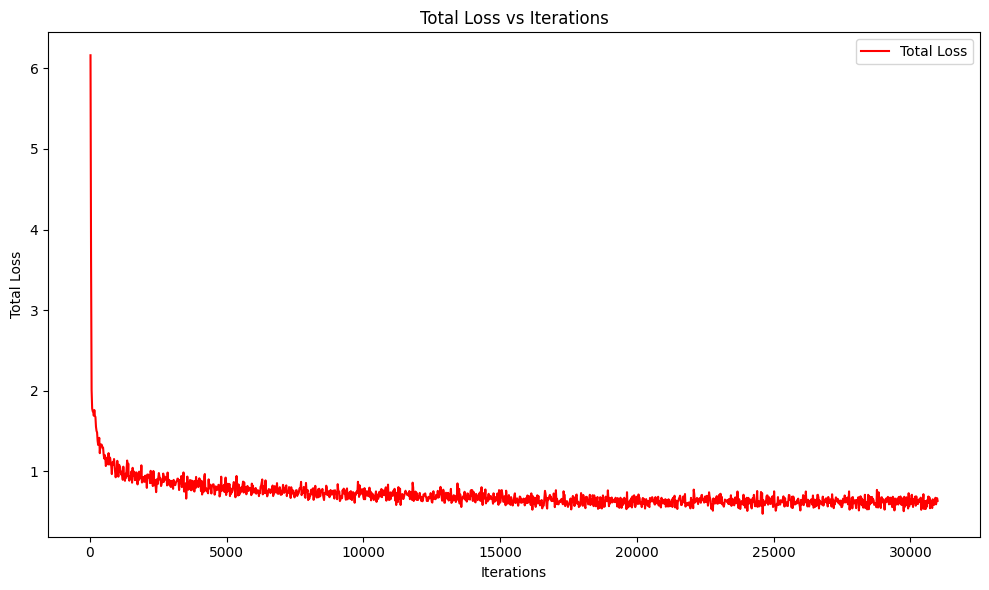

In [3]:
json_file_path = "/content/drive/MyDrive/output_UECFOODPIXCOMPLETE/metrics.json"

data = []
with open(json_file_path, "r") as f:
    for line in f:
        data.append(json.loads(line.strip()))

iterations = []
total_loss_values = []

for entry in data:
    if "iteration" in entry and "total_loss" in entry:
        iterations.append(entry["iteration"])
        total_loss_values.append(entry["total_loss"])
    else:
        continue

plt.figure(figsize=(10, 6))
plt.plot(iterations, total_loss_values, label='Total Loss', color='red')
plt.title("Total Loss vs Iterations")
plt.xlabel("Iterations")
plt.ylabel("Total Loss")
plt.grid(False)
plt.legend()
plt.tight_layout()

plt.show()

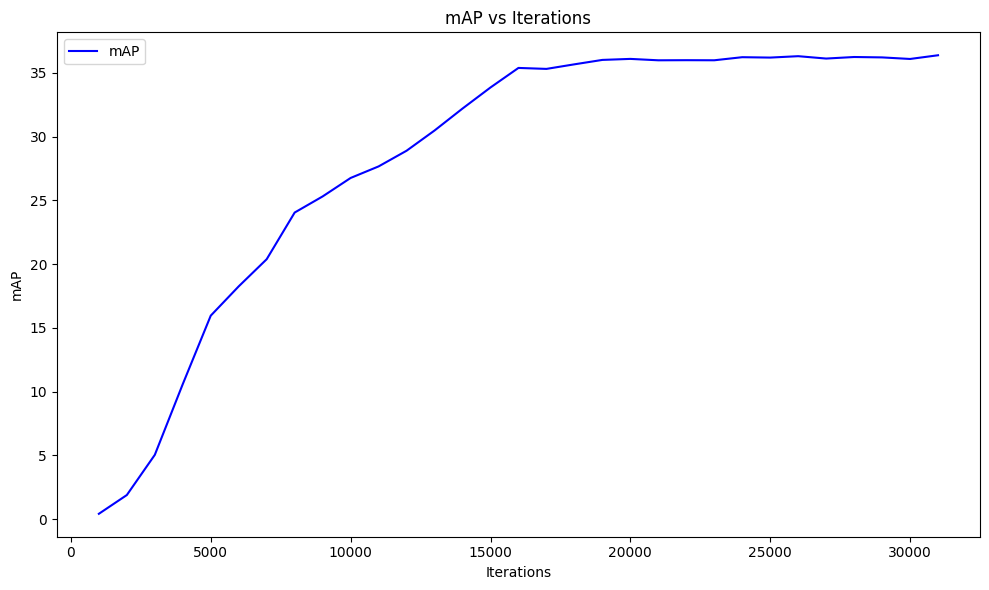

In [4]:
json_file_path = "/content/drive/MyDrive/output_UECFOODPIXCOMPLETE/metrics.json"

data = []
with open(json_file_path, "r") as f:
    for line in f:
        data.append(json.loads(line.strip()))

iterations = []
segm_ap_values = []

for entry in data:
    if "iteration" in entry and "segm/AP" in entry:
        iterations.append(entry["iteration"])
        segm_ap_values.append(entry["segm/AP"])

plt.figure(figsize=(10, 6))
plt.plot(iterations, segm_ap_values, label='mAP', color='blue')
plt.title("mAP vs Iterations")
plt.xlabel("Iterations")
plt.ylabel("mAP")
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
import yaml

with open("/content/drive/MyDrive/Thesis/model_foodseg_POINTREND/model_config.yaml", 'r') as file:
    config = yaml.safe_load(file)

if 'ROI_HEADS' in config['MODEL']:
    if 'CLASS_WEIGHTS' in config['MODEL']['ROI_HEADS']:
        print("Removing CLASS_WEIGHTS from ROI_HEADS...")
        del config['MODEL']['ROI_HEADS']['CLASS_WEIGHTS']
    else:
        print("CLASS_WEIGHTS not found under ROI_HEADS.")
else:
    print("ROI_HEADS not found in the configuration.")

with open('/content/drive/MyDrive/Thesis/model_foodseg_POINTREND/model_config.yaml', 'w') as file:
    yaml.safe_dump(config, file, default_flow_style=False)

Removing CLASS_WEIGHTS from ROI_HEADS...


In [35]:
cfg = get_cfg()
add_pointrend_config(cfg)

cfg.MODEL.MASK_ON = True
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(label_mapping) - 1
cfg.merge_from_file("/content/drive/MyDrive/Thesis/model_foodseg_POINTREND/model_config.yaml")
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/Thesis/model_foodseg_POINTREND/model_final.pth"

cfg.MODEL.ROI_HEADS.NAME = "WeightedROIHeads"
cfg.MODEL.ROI_HEADS.CLASS_WEIGHTS = class_weights
cfg.MODEL.POINT_HEAD.NUM_CLASSES = len(sorted_label_mapping)

test_dataset_name = "foodseg103_test"
test_metadata = MetadataCatalog.get(test_dataset_name)

predictor = DefaultPredictor(cfg)

[12/12 12:32:46 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/Thesis/model_foodseg_POINTREND/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

In [36]:
evaluator = COCOEvaluator(test_dataset_name, cfg, False, output_dir="./evaluation_output/")

val_loader = build_detection_test_loader(cfg, test_dataset_name)

print("Running evaluation...")
results = inference_on_dataset(predictor.model, val_loader, evaluator)

print("Evaluation Results:", results)

WARNING [12/12 12:35:33 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[12/12 12:35:33 d2.evaluation.coco_evaluation]: Trying to convert 'foodseg103_test' to COCO format ...
[12/12 12:35:33 d2.data.datasets.coco]: Converting annotations of dataset 'foodseg103_test' to COCO format ...)
[12/12 12:35:43 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[12/12 12:35:44 d2.data.datasets.coco]: Conversion finished, #images: 1000, #annotations: 1949
[12/12 12:35:44 d2.data.datasets.coco]: Caching COCO format annotations at './evaluation_output/foodseg103_test_coco_format.json' ...
[12/12 12:35:49 d2.data.build]: Distribution of instances among all 103 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
|  background   | 0           

/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/12 12:35:53 d2.evaluation.evaluator]: Inference done 11/1000. Dataloading: 0.0013 s/iter. Inference: 0.0487 s/iter. Eval: 0.0032 s/iter. Total: 0.0532 s/iter. ETA=0:00:52
[12/12 12:35:58 d2.evaluation.evaluator]: Inference done 111/1000. Dataloading: 0.0015 s/iter. Inference: 0.0454 s/iter. Eval: 0.0036 s/iter. Total: 0.0505 s/iter. ETA=0:00:44
[12/12 12:36:03 d2.evaluation.evaluator]: Inference done 216/1000. Dataloading: 0.0015 s/iter. Inference: 0.0428 s/iter. Eval: 0.0048 s/iter. Total: 0.0492 s/iter. ETA=0:00:38
[12/12 12:36:08 d2.evaluation.evaluator]: Inference done 321/1000. Dataloading: 0.0015 s/iter. Inference: 0.0417 s/iter. Eval: 0.0055 s/iter. Total: 0.0488 s/iter. ETA=0:00:33
[12/12 12:36:13 d2.evaluation.evaluator]: Inference done 432/1000. Dataloading: 0.0015 s/iter. Inference: 0.0413 s/iter. Eval: 0.0050 s/iter. Total: 0.0479 s/iter. ETA=0:00:27
[12/12 12:36:18 d2.evaluation.evaluator]: Inference done 544/1000. Dataloading: 0.0015 s/iter. Inference: 0.0409 s/iter. 

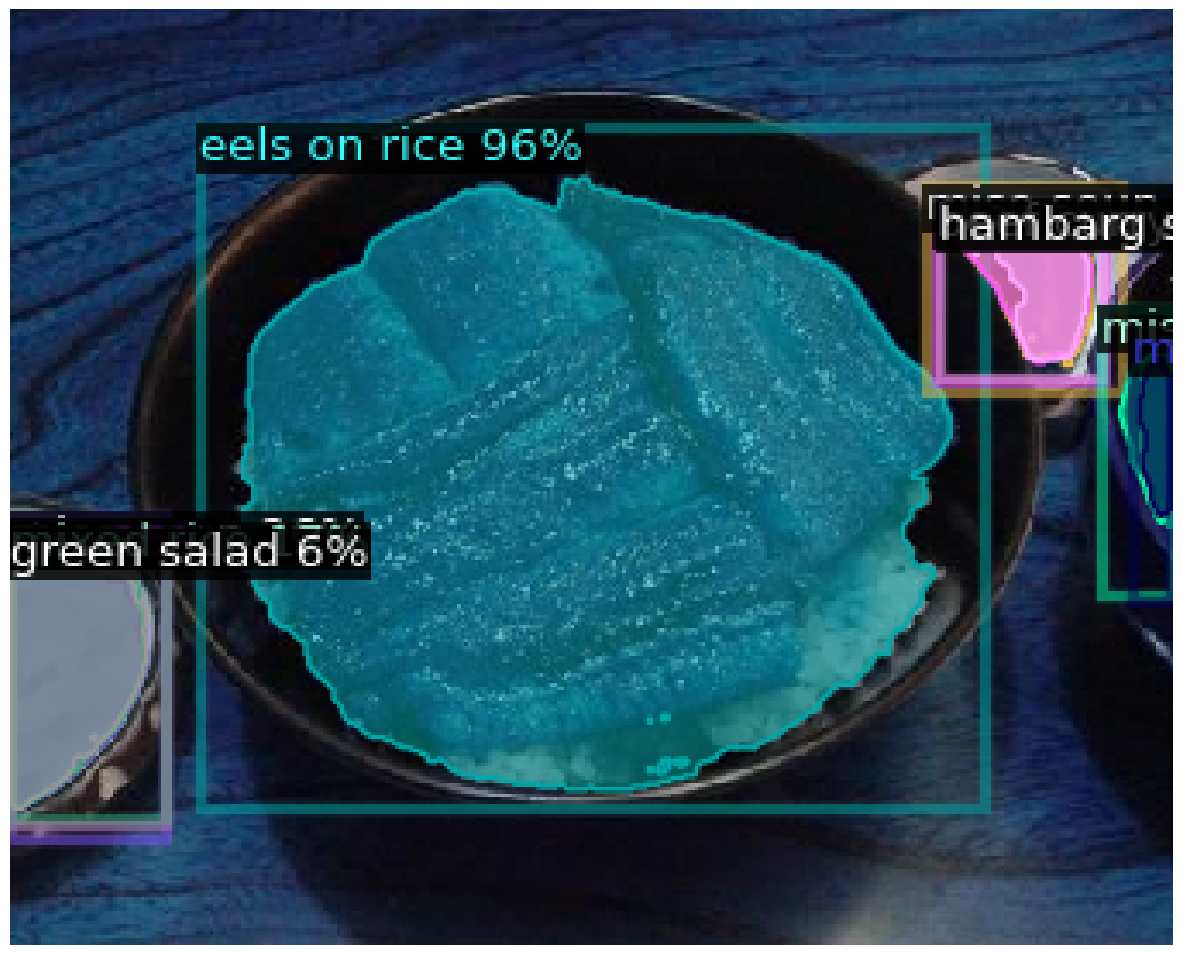

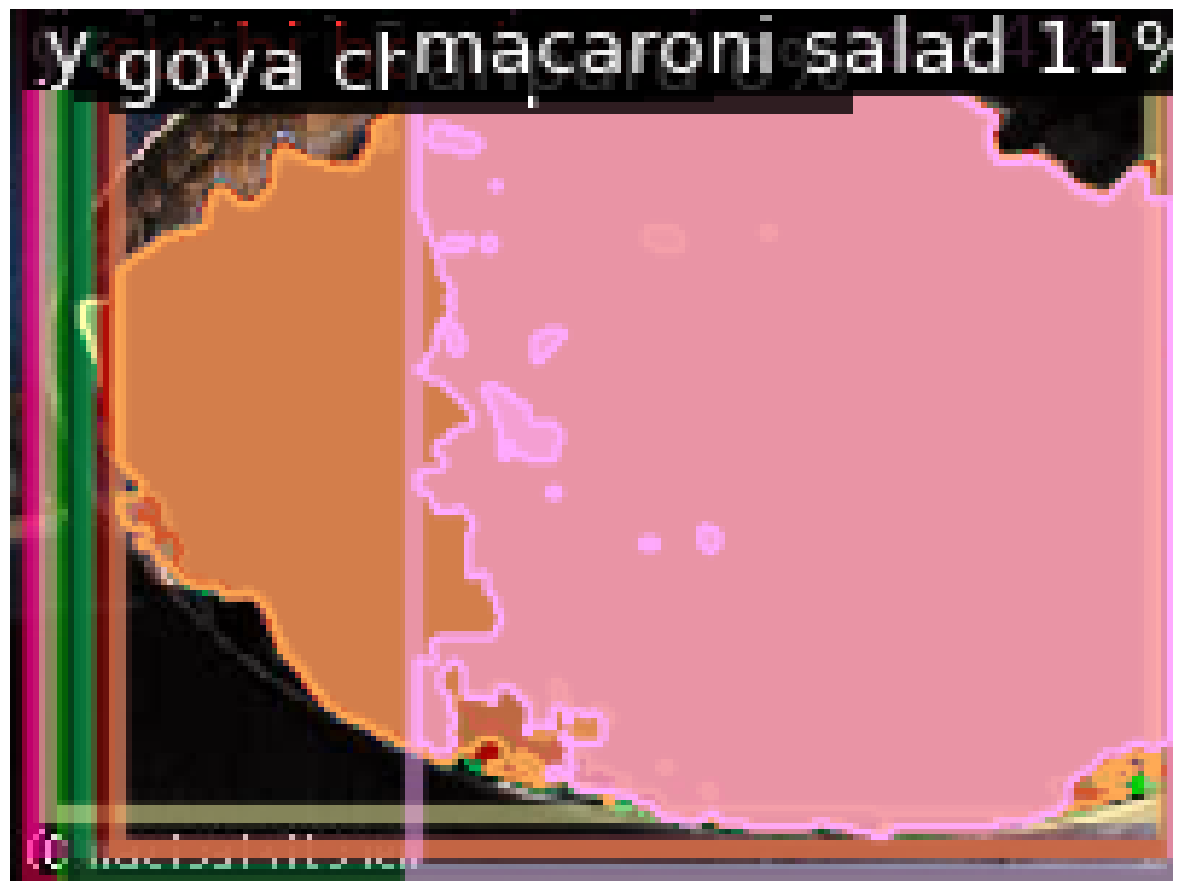

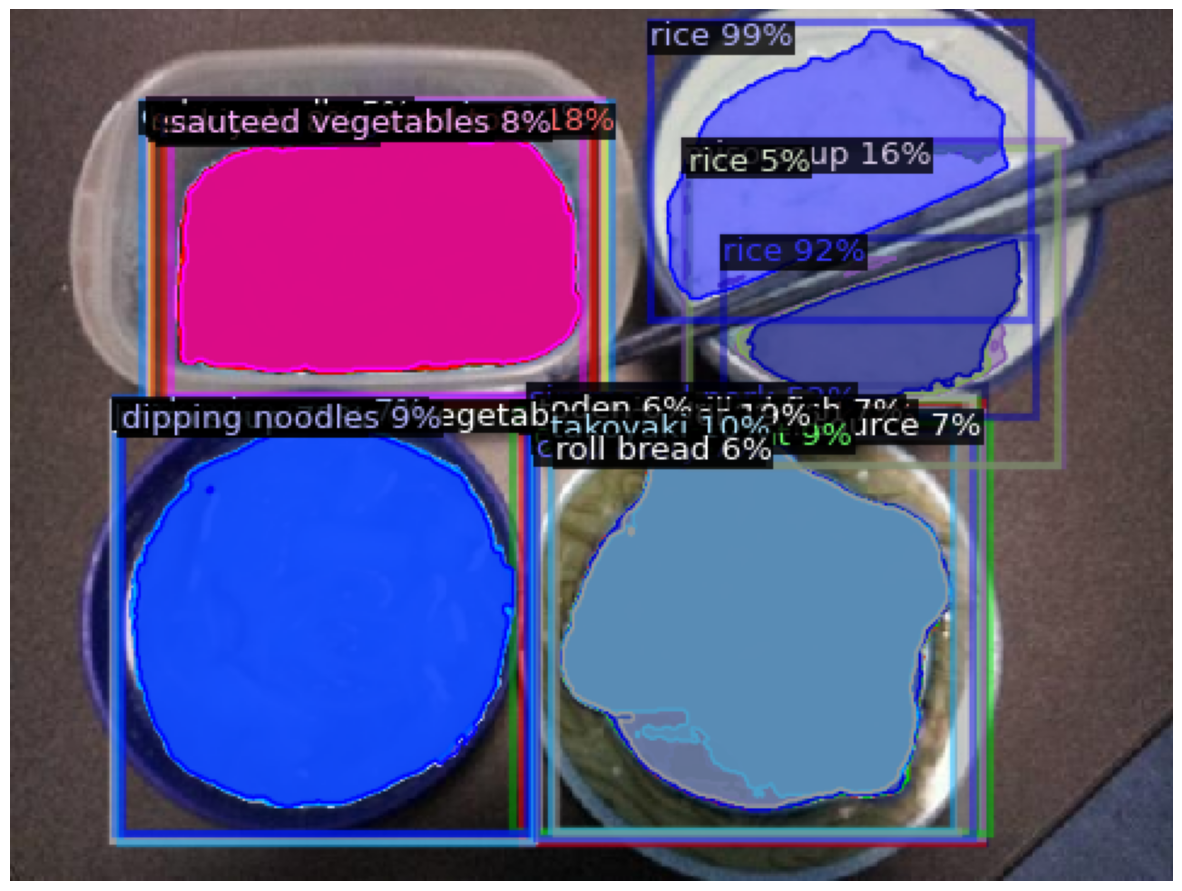

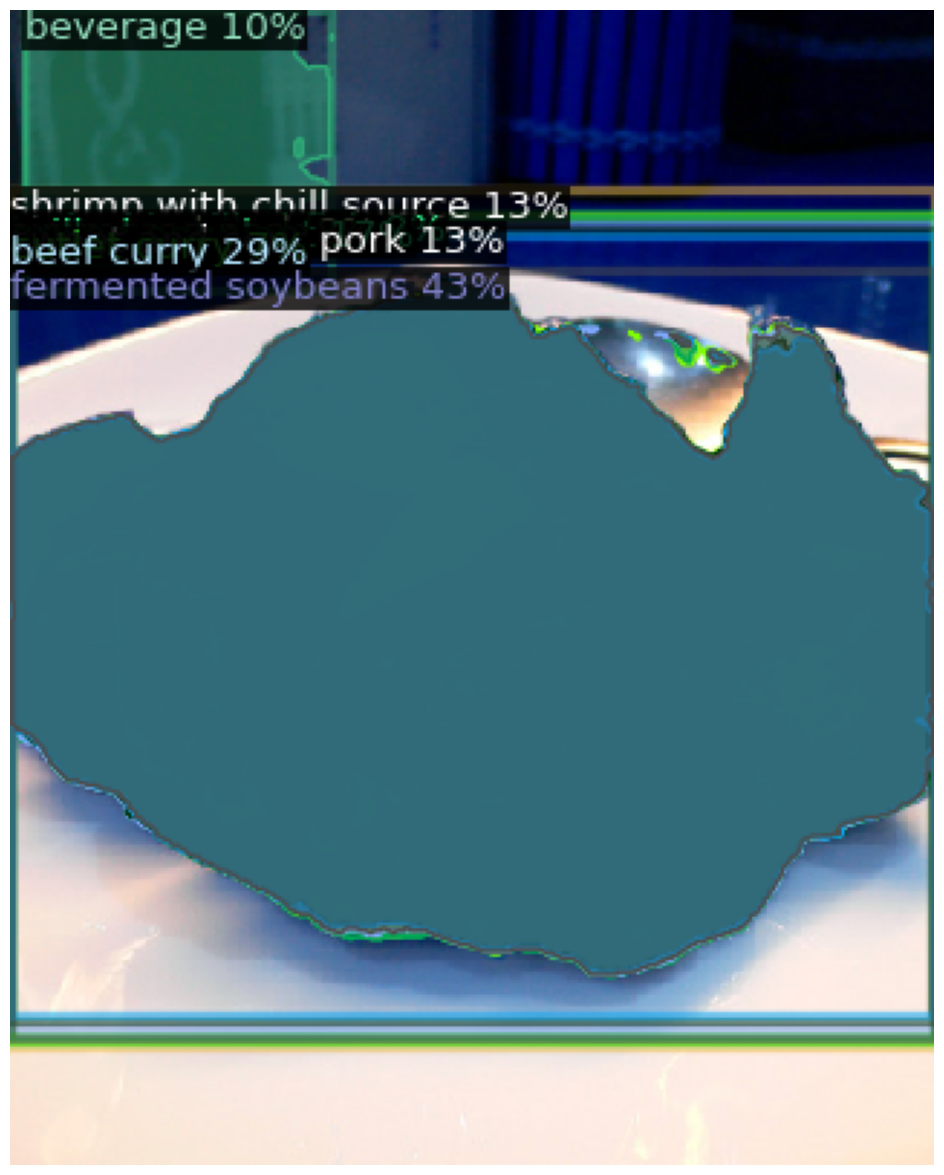

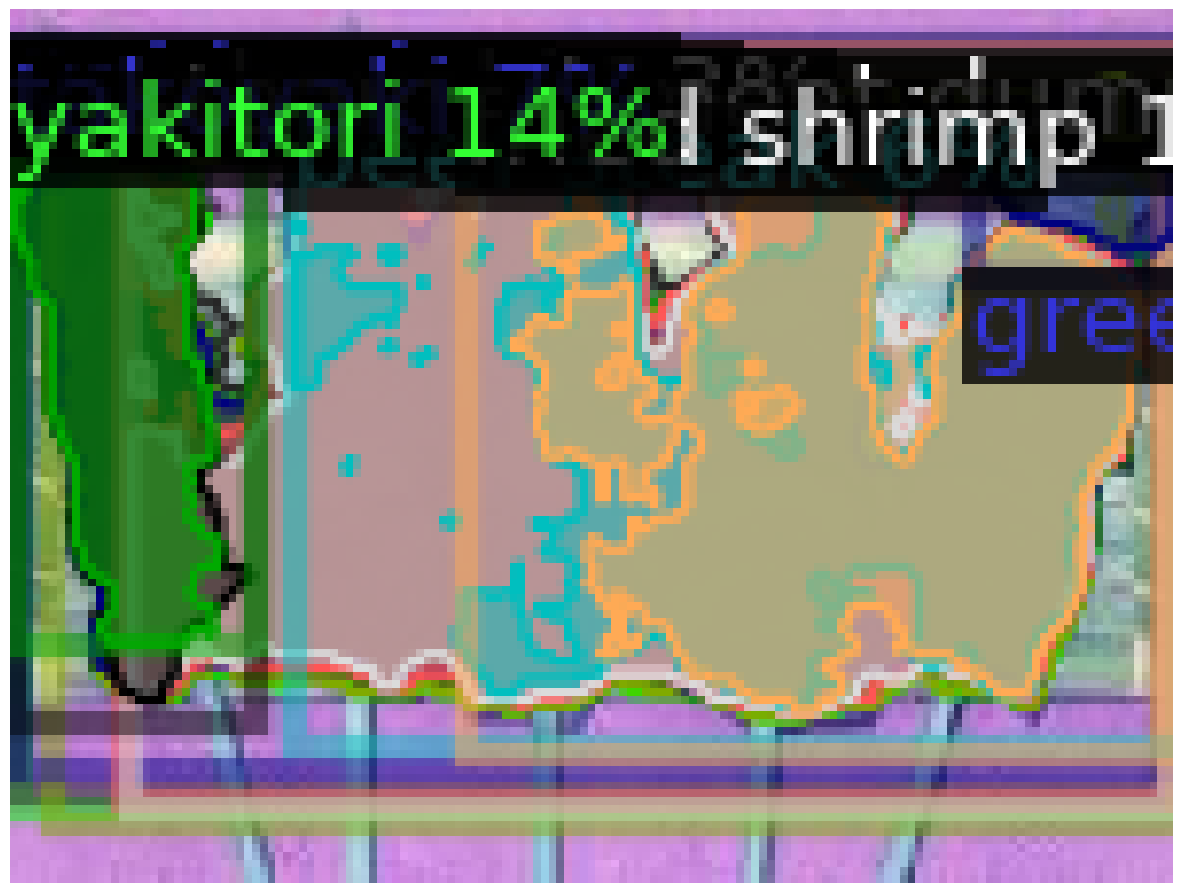

In [38]:
for d in random.sample(test_dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    if img is None:
        print(f"Could not load image {d['file_name']}")
        continue

    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1], metadata=foodseg_metadata_test, scale=0.5)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    plt.figure(figsize=(15, 15))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis("off")
    plt.show()

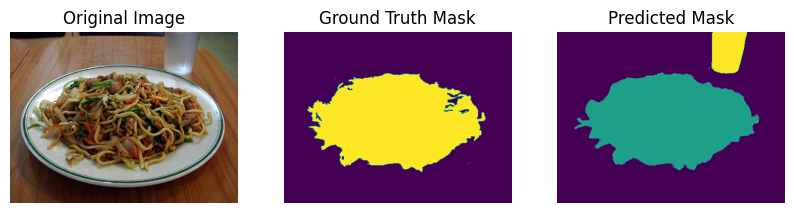

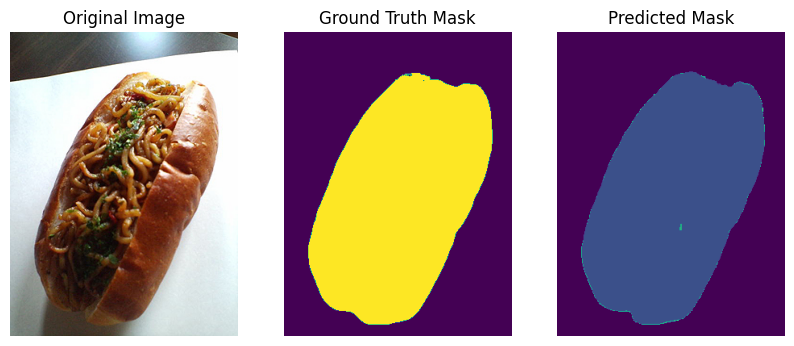

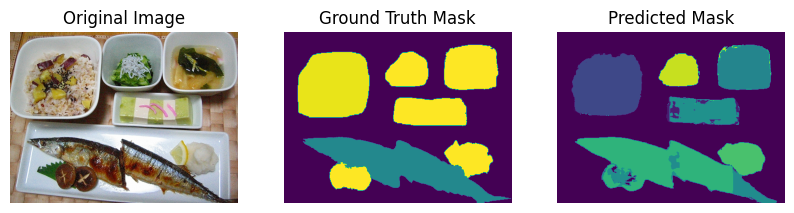

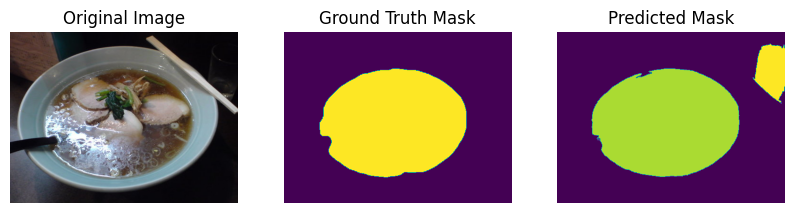

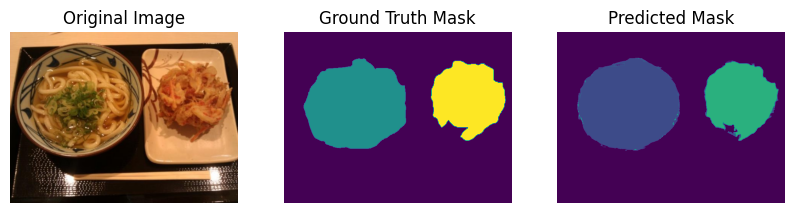

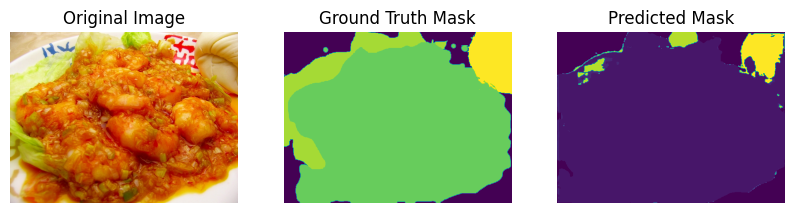

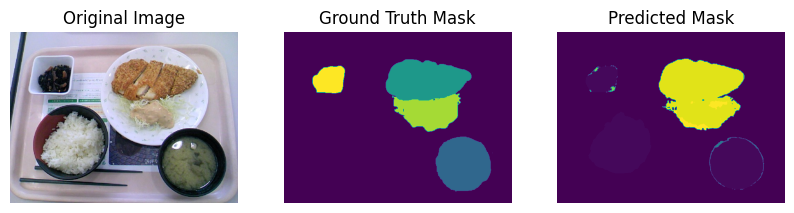

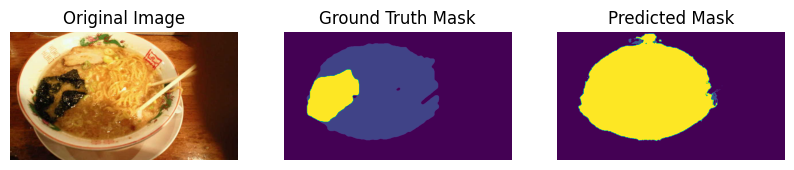

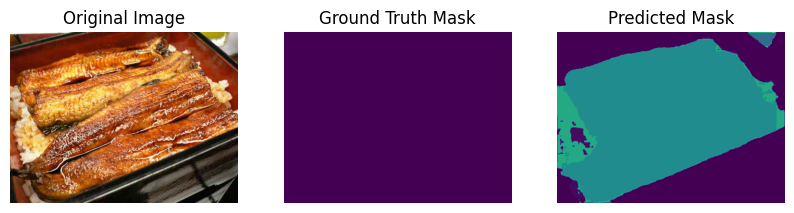

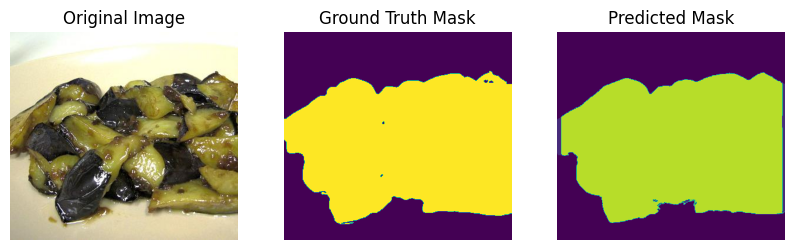

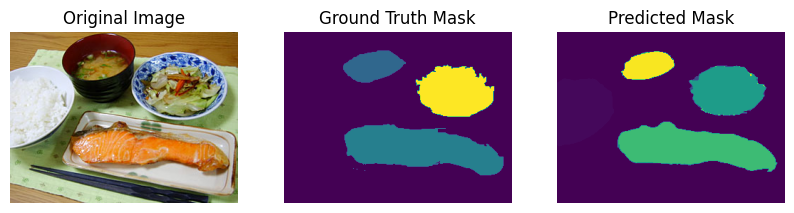

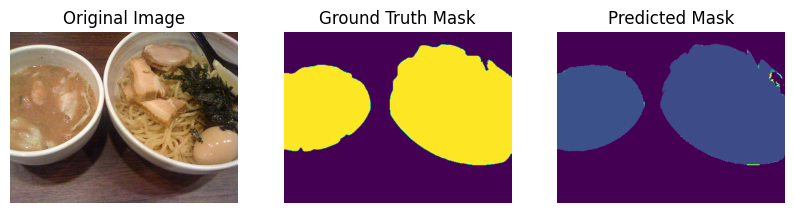

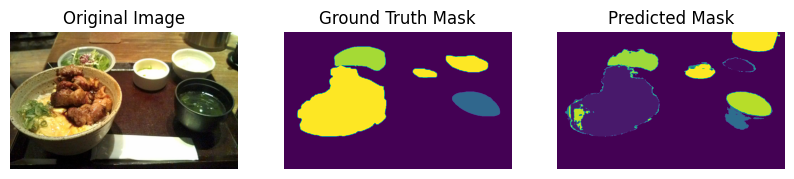

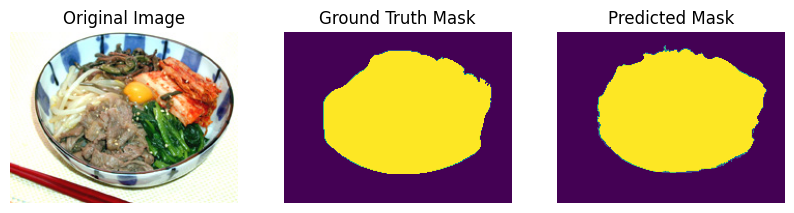

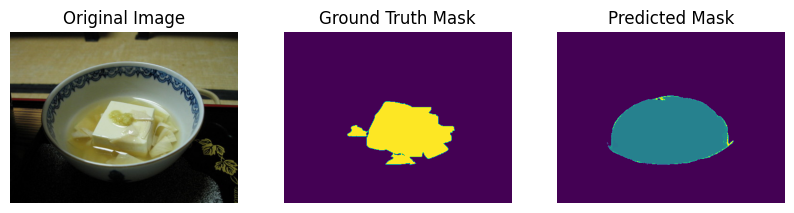

In [41]:
for d in random.sample(test_dataset_dicts, 15):
    img = cv2.imread(d["file_name"])
    if img is None:
        continue

    gt_mask_path = d["sem_seg_file_name"]
    gt_mask = cv2.imread(gt_mask_path, cv2.IMREAD_GRAYSCALE)

    outputs = predictor(img)
    pred_masks = outputs["instances"].pred_masks.cpu().numpy()
    pred_classes = outputs["instances"].pred_classes.cpu().numpy()

    pred_mask = np.zeros_like(gt_mask, dtype=np.uint8)
    for idx, cls in enumerate(pred_classes):
        pred_mask[pred_masks[idx]] = cls + 1

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(gt_mask, cmap="viridis")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask, cmap="viridis")
    plt.axis("off")

    plt.show()